<a href="https://colab.research.google.com/github/olcaykursun/ML/blob/main/Fall2025/Week13/Autoencoders_for_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Device: cuda
AE Epoch 1/3, Loss: 0.0391
AE Epoch 2/3, Loss: 0.0052
AE Epoch 3/3, Loss: 0.0040


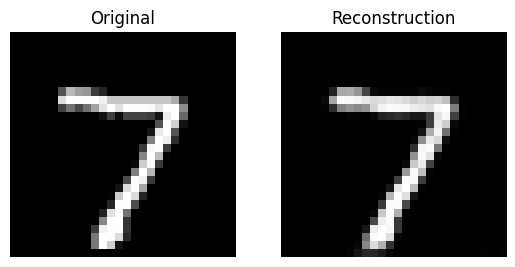

Encoded feature shape: torch.Size([500, 1568])
Classifier Epoch 1/5, Loss: 2.3653, Acc: 0.261
Classifier Epoch 2/5, Loss: 1.4655, Acc: 0.526
Classifier Epoch 3/5, Loss: 0.9531, Acc: 0.713
Classifier Epoch 4/5, Loss: 0.7209, Acc: 0.832
Classifier Epoch 5/5, Loss: 0.5665, Acc: 0.878
Test accuracy (AE features): 79.38%
Baseline Epoch 1/5, Loss: 2.2648, Acc: 0.129
Baseline Epoch 2/5, Loss: 2.1331, Acc: 0.400
Baseline Epoch 3/5, Loss: 1.8793, Acc: 0.632
Baseline Epoch 4/5, Loss: 1.4814, Acc: 0.718
Baseline Epoch 5/5, Loss: 1.0272, Acc: 0.784
Test accuracy (raw pixels): 75.31%
Fine-tune (frozen) Epoch 1/5, Loss: 2.1240, Acc: 0.367
Fine-tune (frozen) Epoch 2/5, Loss: 1.2304, Acc: 0.658
Fine-tune (frozen) Epoch 3/5, Loss: 0.8317, Acc: 0.786
Fine-tune (frozen) Epoch 4/5, Loss: 0.6303, Acc: 0.853
Fine-tune (frozen) Epoch 5/5, Loss: 0.5226, Acc: 0.868
Fine-tune (all) Epoch 1/5, Loss: 0.4568, Acc: 0.890
Fine-tune (all) Epoch 2/5, Loss: 0.4311, Acc: 0.887
Fine-tune (all) Epoch 3/5, Loss: 0.4117, Ac

In [1]:
# =============================================================
# AutoEncoder Pretraining + Small Classifier vs Raw Baseline
# AUM Machine Learning - Dr. Olcay Kursun
# Simplified Teaching Version (with Visualization + Fine-tuning)
# =============================================================

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, TensorDataset
import matplotlib.pyplot as plt

# -------------------------------------------------------------
# 0. Setup
# -------------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# -------------------------------------------------------------
# 1. Data Loading
# -------------------------------------------------------------
transform = transforms.ToTensor()

train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset  = datasets.MNIST(root="./data", train=False, transform=transform)

# Many examples for AE pretraining, few for classifier
all_indices = torch.randperm(len(train_dataset))
ae_indices  = all_indices[:50000]
clf_indices = all_indices[50000:50500]  # small labeled subset (500)

ae_subset  = Subset(train_dataset, ae_indices)
clf_subset = Subset(train_dataset, clf_indices)

ae_loader   = DataLoader(ae_subset, batch_size=128, shuffle=True)
clf_loader  = DataLoader(clf_subset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# -------------------------------------------------------------
# 2. AutoEncoder Definition
# -------------------------------------------------------------
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, z

# -------------------------------------------------------------
# 3. AutoEncoder Training
# -------------------------------------------------------------
def train_autoencoder(model, dataloader, epochs=3):
    model.train()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    for epoch in range(epochs):
        total_loss = 0
        for imgs, _ in dataloader:
            imgs = imgs.to(device)
            optimizer.zero_grad()
            outputs, _ = model(imgs)
            loss = criterion(outputs, imgs)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"AE Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(dataloader):.4f}")

autoencoder = AutoEncoder().to(device)
train_autoencoder(autoencoder, ae_loader, epochs=3)

# -------------------------------------------------------------
# 3.1. Visualize Reconstruction
# -------------------------------------------------------------
autoencoder.eval()
imgs, _ = next(iter(test_loader))
recon, _ = autoencoder(imgs.to(device))

plt.subplot(1, 2, 1)
plt.imshow(imgs[0][0], cmap="gray")
plt.title("Original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(recon[0][0].detach().cpu(), cmap="gray")
plt.title("Reconstruction")
plt.axis("off")

plt.show()

# -------------------------------------------------------------
# 4. Encode Data (Extract Latent Features)
# -------------------------------------------------------------
def get_encoded(model, loader):
    model.eval()
    feats, labels = [], []
    with torch.no_grad():
        for imgs, lbls in loader:
            imgs = imgs.to(device)
            _, z = model(imgs)
            feats.append(z.view(z.size(0), -1).cpu())
            labels.append(lbls)
    return torch.cat(feats), torch.cat(labels)

x_train, y_train = get_encoded(autoencoder, clf_loader)
x_test,  y_test  = get_encoded(autoencoder, test_loader)

print("Encoded feature shape:", x_train.shape)

# -------------------------------------------------------------
# 5. Classifier on Encoded Features
# -------------------------------------------------------------
class Classifier(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 10)
        )

    def forward(self, x):
        return self.net(x)

clf = Classifier(x_train.shape[1]).to(device)

train_data = TensorDataset(x_train, y_train)
test_data  = TensorDataset(x_test, y_test)
train_loader_clf = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader_clf  = DataLoader(test_data, batch_size=128, shuffle=False)

def train_classifier(model, loader, epochs=5):
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    for epoch in range(epochs):
        total_loss, total_acc = 0, 0
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            total_acc += (out.argmax(1) == y).float().mean().item()
        print(f"Classifier Epoch {epoch+1}/{epochs}, "
              f"Loss: {total_loss/len(loader):.4f}, Acc: {total_acc/len(loader):.3f}")

train_classifier(clf, train_loader_clf, epochs=5)

# Evaluate classifier
clf.eval()
correct, total = 0, 0
with torch.no_grad():
    for x, y in test_loader_clf:
        x, y = x.to(device), y.to(device)
        preds = clf(x).argmax(1)
        correct += (preds == y).sum().item()
        total += y.size(0)
print(f"Test accuracy (AE features): {100 * correct / total:.2f}%")

# -------------------------------------------------------------
# 6. Baseline: CNN Classifier on Raw Pixels (No AE)
# -------------------------------------------------------------
class ClassifierRaw(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(7 * 7 * 32, 10)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.classifier(x)
        return x

baseline = ClassifierRaw().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(baseline.parameters(), lr=1e-3)

for epoch in range(5):
    total_loss, total_acc = 0, 0
    for imgs, labels in clf_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        out = baseline(imgs)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_acc += (out.argmax(1) == labels).float().mean().item()
    print(f"Baseline Epoch {epoch+1}/5, "
          f"Loss: {total_loss/len(clf_loader):.4f}, Acc: {total_acc/len(clf_loader):.3f}")

# Evaluate baseline
baseline.eval()
correct, total = 0, 0
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        preds = baseline(imgs).argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
print(f"Test accuracy (raw pixels): {100 * correct / total:.2f}%")

# -------------------------------------------------------------
# 7. Fine-Tuning: Encoder + Classifier (End-to-End)
# -------------------------------------------------------------
class EncoderClassifier(nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.encoder = encoder
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(7*7*32, 10)
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.classifier(z)

model = EncoderClassifier(autoencoder.encoder).to(device)

# Phase 1: Train only the classifier (encoder frozen)
for param in model.encoder.parameters():
    param.requires_grad = False

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(5):
    total_loss, total_acc = 0, 0
    for imgs, labels in clf_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        out = model(imgs)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_acc += (out.argmax(1) == labels).float().mean().item()
    print(f"Fine-tune (frozen) Epoch {epoch+1}/5, "
          f"Loss: {total_loss/len(clf_loader):.4f}, Acc: {total_acc/len(clf_loader):.3f}")

# Phase 2: Unfreeze encoder and fine-tune all layers
for param in model.encoder.parameters():
    param.requires_grad = True

optimizer = optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(5):
    total_loss, total_acc = 0, 0
    for imgs, labels in clf_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        out = model(imgs)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_acc += (out.argmax(1) == labels).float().mean().item()
    print(f"Fine-tune (all) Epoch {epoch+1}/5, "
          f"Loss: {total_loss/len(clf_loader):.4f}, Acc: {total_acc/len(clf_loader):.3f}")

# -------------------------------------------------------------
# Evaluate Encoder+Classifier on Test Set
# -------------------------------------------------------------
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        preds = model(imgs).argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
print(f"Test accuracy (Encoder+Classifier): {100 * correct / total:.2f}%")
